# Exploratory Data Analysis and Preprocessing

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [46]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [47]:
print(tf.__version__)

2.19.0


In [ ]:
df = pd.read_csv("../data.csv")
df.head()

,Tweet,Label
0,A little throwback with my favourite person @ ...,0
1,glam on @user yesterday for #kcon makeup using...,7
2,Democracy Plaza in the wake of a stunning outc...,11
3,Then &amp; Now. VILO @ Walt Disney Magic Kingdom,0
4,Who never... @ A Galaxy Far Far Away,2


In [49]:
# df = df.drop(columns=[df.columns[0]])
# df = df.rename(columns={'TEXT': 'Tweet'})
# df.head()

/tmp/ipython-input-152243291.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Label", data=df, palette="husl")


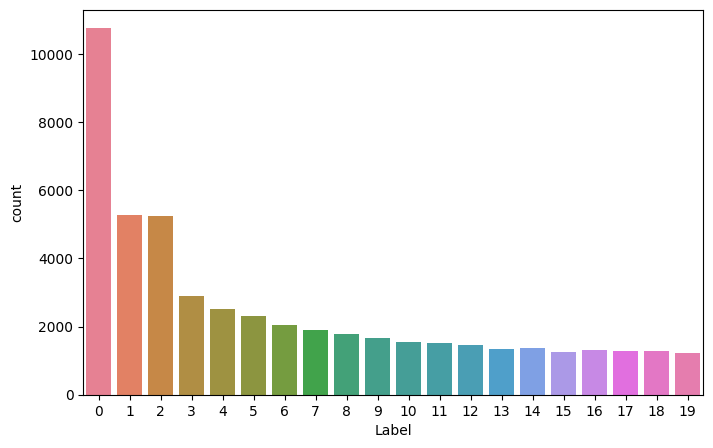

In [50]:
plt.figure(figsize=(8,5))
sns.countplot(x="Label", data=df, palette="husl")
plt.show()

<Figure size 800x500 with 0 Axes>

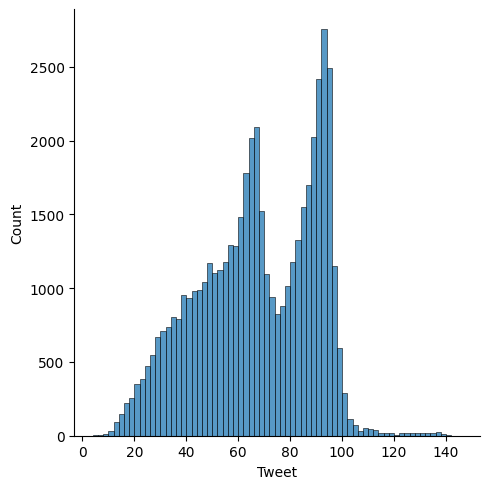

In [51]:
plt.figure(figsize=(8,5))
sns.displot(df['Tweet'].apply(len))
plt.show()

## Pre-processing the Dataset

In [52]:
import re
import string, nltk, spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [53]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [54]:
df = df.drop_duplicates(subset="Tweet").reset_index(drop=True) # Remove the duplicate values

In [55]:
def preprocessing(text):
    text = text.lower() #make the text lowercase
    text = re.sub(r'\brt\b', '', text)# remove RT
    text = re.sub(r'@ \w+', '', text) #remove @mentions
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text) # removing the has symbol
    text = re.sub(r'\d+', '', text) #removing number
    text = re.sub(r'http\S+|www\S+', '', text) # removing url
    text = text.translate(str.maketrans('', '', string.punctuation)) #removing punctuation
    text = re.sub(r'\s+', ' ', text).strip() #removing extra-spaces
    text = " ".join([w for w in text.split() if w not in stop_words])
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    return text

df['processed_tweet'] = df['Tweet'].apply(preprocessing)


In [56]:
df.head()

,Tweet,Label,processed_tweet
0,A little throwback with my favourite person @ ...,0,little throwback favourite person wall
1,glam on @user yesterday for #kcon makeup using...,7,glam yesterday kcon makeup using featherette…
2,Democracy Plaza in the wake of a stunning outc...,11,democracy plaza wake stunning outcome decision...
3,Then &amp; Now. VILO @ Walt Disney Magic Kingdom,0,amp vilo disney magic kingdom
4,Who never... @ A Galaxy Far Far Away,2,never galaxy far far away


## Modeling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM, Bidirectional, Embedding, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [70]:
X = df['processed_tweet'].values.reshape(-1,1)
y = df['Label'].values

os = RandomOverSampler()
X, y = os.fit_resample(X, y)
X = X.reshape(-1,)

In [81]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)

In [82]:
tokenizer = Tokenizer(num_words=80000)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(sequences, padding='pre', truncating='pre', maxlen=40)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.3, random_state=105)

In [86]:
model = Sequential([
    Embedding(len(tokenizer.word_index)+1, 128, input_length=40),
    Bidirectional(LSTM(80, return_sequences=True)),
    Bidirectional(LSTM(80, return_sequences=True)),
    GlobalMaxPool1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')
])


In [87]:
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=1,verbose=1)

In [88]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop])


Epoch 1/15
2346/2346 ━━━━━━━━━━━━━━━━━━━━ 55s 21ms/step - accuracy: 0.1574 - loss: 2.7052 - val_accuracy: 0.5386 - val_loss: 1.5401
Epoch 2/15
2346/2346 ━━━━━━━━━━━━━━━━━━━━ 52s 22ms/step - accuracy: 0.6047 - loss: 1.3342 - val_accuracy: 0.7177 - val_loss: 0.9653
Epoch 3/15
2346/2346 ━━━━━━━━━━━━━━━━━━━━ 49s 21ms/step - accuracy: 0.7673 - loss: 0.7938 - val_accuracy: 0.7841 - val_loss: 0.7703
Epoch 4/15
2346/2346 ━━━━━━━━━━━━━━━━━━━━ 49s 21ms/step - accuracy: 0.8318 - loss: 0.5812 - val_accuracy: 0.8160 - val_loss: 0.6898
Epoch 5/15
2346/2346 ━━━━━━━━━━━━━━━━━━━━ 83s 21ms/step - accuracy: 0.8703 - loss: 0.4527 - val_accuracy: 0.8405 - val_loss: 0.6356
Epoch 6/15
2346/2346 ━━━━━━━━━━━━━━━━━━━━ 48s 21ms/step - accuracy: 0.8966 - loss: 0.3629 - val_accuracy: 0.8536 - val_loss: 0.6158
Epoch 7/15
2346/2346 ━━━━━━━━━━━━━━━━━━━━ 48s 21ms/step - accuracy: 0.9111 - loss: 0.3134 - val_accuracy: 0.8698 - val_loss: 0.5950
Epoch 8/15
2346/2346 ━━━━━━━━━━━━━━━━━━━━ 49s 21ms/step - accuracy: 0.9242 -

In [90]:
val_acc = history.history['val_accuracy']
print(val_acc[-1])

0.8835835456848145


In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# val_acc = history.history['val_accuracy']
# print("Validation Accuracy:", val_acc[-1])

# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# y_true = y_test

# cm = confusion_matrix(y_true, y_pred_classes)

# plt.figure(figsize=(12, 10))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()

# print(classification_report(y_true, y_pred_classes))
